<a href="https://colab.research.google.com/github/meetptl04/ImageStyleTranfer/blob/main/Final_of_ImageStryleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

## Image Processing Class
* The `ImageProcessing` class provides static methods for loading and processing images for neural network input, and for converting processed images back to a viewable format. Specifically, it resizes and normalizes images for VGG19 and performs de-normalization for display.

In [52]:
import tensorflow as tf
import numpy as np

class ImageProcessing:
    @staticmethod
    def load_and_process_img(path_to_img):
        """Load and process an image from a file path for VGG model input."""
        max_dim = 512
        img = tf.keras.preprocessing.image.load_img(path_to_img)
        img = tf.keras.preprocessing.image.img_to_array(img)

        # Resize to maintain aspect ratio
        long = max(img.shape[:-1])
        scale = max_dim / long
        img = tf.image.resize(img, (round(img.shape[0] * scale), round(img.shape[1] * scale)))
        img = tf.keras.applications.vgg19.preprocess_input(img)
        img = np.expand_dims(img, axis=0)
        return img

    @staticmethod
    def load_and_process_tensor(image_tensor):
        """Process an image tensor directly for VGG model input."""
        max_dim = 512
        # Resize image while keeping aspect ratio
        long = tf.reduce_max(image_tensor.shape[:-1])
        scale = max_dim / tf.cast(long, tf.float32)
        # new_shape = tf.cast(tf.shape(image_tensor)[:2] * scale, tf.int32)
        # image_tensor = tf.image.resize(image_tensor, new_shape)
        new_shape = tf.cast(tf.shape(image_tensor)[:2] * tf.cast(scale, tf.int32), tf.int32)

        image_tensor = tf.image.resize(image_tensor, new_shape)
        # Preprocess for VGG19
        image_tensor = tf.keras.applications.vgg19.preprocess_input(image_tensor * 255.0)
        image_tensor = tf.expand_dims(image_tensor, axis=0)
        return image_tensor

    @staticmethod
    def deprocess_img(processed_img):
        """Revert preprocessing for display."""
        x = processed_img.copy()
        if len(x.shape) == 4:
            x = np.squeeze(x, 0)
        x[:, :, 0] += 103.939
        x[:, :, 1] += 116.779
        x[:, :, 2] += 123.68
        x = x[:, :, ::-1]
        x = np.clip(x, 0, 255).astype('uint8')
        return x


## Loss Function Class
* This class defines a model that calculates the style and content loss for image style transfer.

In [53]:
# Loss Functions Class
class LossFunctions:
    @staticmethod
    def get_content_loss(base_content, target):
        return tf.reduce_mean(tf.square(base_content - target))

    @staticmethod
    def gram_matrix(input_tensor):
        channels = int(input_tensor.shape[-1])
        a = tf.reshape(input_tensor, [-1, channels])
        n = tf.shape(a)[0]
        gram = tf.matmul(a, a, transpose_a=True)
        return gram / tf.cast(n, tf.float32)

    @staticmethod
    def get_style_loss(base_style, gram_target):
        height, width, channels = base_style.get_shape().as_list()
        gram_style = LossFunctions.gram_matrix(base_style)
        return tf.reduce_mean(tf.square(gram_style - gram_target))

## VGG Model Class
* The `VGGModel` class initializes a VGG19 model pre-trained on ImageNet, extracts feature representations for content and style images, and provides methods to obtain these features for style transfer tasks.

In [54]:
# VGG Model Class
class VGGModel:
    def __init__(self):
        self.model = self._get_model()

    def _get_model(self):
        vgg = VGG19(include_top=False, weights='imagenet')
        vgg.trainable = False

        content_layers = ['block5_conv2']
        style_layers = ['block1_conv1', 'block2_conv1',
                        'block3_conv1', 'block4_conv1',
                        'block5_conv1']

        content_output = [vgg.get_layer(layer).output for layer in content_layers]
        style_outputs = [vgg.get_layer(layer).output for layer in style_layers]

        model_outputs = style_outputs + content_output

        return Model(vgg.input, model_outputs)

    def get_feature_representations(self, content_image_tensor, style_image_tensor):
        """Extract feature representations for content and style images passed as tensors."""
        # Process the images to be compatible with VGG19 input
        content_image = ImageProcessing.load_and_process_tensor(content_image_tensor)
        style_image = ImageProcessing.load_and_process_tensor(style_image_tensor)

        # Extract feature representations
        content_features = self.model(content_image)[-1]
        style_features = self.model(style_image)[:-1]

        return style_features, content_features


## Style Transfer Class
* The `StyleTransfer` class handles the process of applying style transfer to an image using a VGG19 model. It computes losses for style and content features, calculates gradients to update the image, and iteratively optimizes the image to match the style of one image and the content of another. It provides methods to compute losses and gradients, and to perform style transfer over a specified number of iterations, returning the final stylized image and its associated loss.

In [73]:
import tensorflow as tf
import numpy as np

# Style Transfer Class
class StyleTransfer:
    def __init__(self, vgg_model, style_weight=1e-2, content_weight=1e4):
        self.vgg_model = vgg_model
        self.style_weight = tf.cast(style_weight, tf.float32)  # Ensure float type
        self.content_weight = tf.cast(content_weight, tf.float32)  # Ensure float type

    def compute_loss(self, init_image, gram_style_features, content_features):
      # model_outputs = self.vgg_model.model(init_image)
      init_image = init_image[tf.newaxis, ...]  # Reshape to (1, height, width, channels)

      model_outputs = self.vgg_model.model(init_image)

      style_output_features = model_outputs[:len(gram_style_features)]
      content_output_features = model_outputs[len(gram_style_features):]

      style_score = 0.0  # Make sure this is a float
      content_score = 0.0  # Same here

      weight_per_style_layer = 1.0 / float(len(gram_style_features))
      for target_style, comb_style in zip(gram_style_features, style_output_features):
          style_score += weight_per_style_layer * LossFunctions.get_style_loss(comb_style[0], target_style)

      weight_per_content_layer = 1.0 / float(len(content_features))
      for target_content, comb_content in zip(content_features, content_output_features):
          content_score += weight_per_content_layer * LossFunctions.get_content_loss(comb_content[0], target_content)

      style_score *= self.style_weight  # Ensure style_weight is float32
      content_score *= self.content_weight  # Ensure content_weight is float32

      loss = style_score + content_score
      return loss, style_score, content_score



    def compute_grads(self, init_image, gram_style_features, content_features):
        with tf.GradientTape() as tape:
            all_loss = self.compute_loss(init_image, gram_style_features, content_features)
        total_loss = all_loss[0]
        return tape.gradient(total_loss, init_image), all_loss

    def run_style_transfer(self, content_image_tensor, style_image_tensor, num_iterations=1000):
      # Ensure that the input tensors are of type float32
      content_image_tensor = tf.cast(content_image_tensor, tf.float32)
      style_image_tensor = tf.cast(style_image_tensor, tf.float32)

      # Get feature representations
      style_features, content_features = self.vgg_model.get_feature_representations(content_image_tensor, style_image_tensor)
      gram_style_features = [LossFunctions.gram_matrix(style_feature) for style_feature in style_features]

      # Initialize the image
      init_image = tf.Variable(content_image_tensor, dtype=tf.float32)


      # Adam optimizer
      opt = tf.optimizers.Adam(learning_rate=5.0, beta_1=0.99, epsilon=1e-1)

      best_loss, best_img = float('inf'), None
      norm_means = np.array([103.939, 116.779, 123.68])
      min_vals = -norm_means
      max_vals = 255 - norm_means

      for i in range(num_iterations):
          grads, all_loss = self.compute_grads(init_image, gram_style_features, content_features)
          loss, style_score, content_score = all_loss
          opt.apply_gradients([(grads, init_image)])

          # Clip the image values
          clipped = tf.clip_by_value(init_image, min_vals, max_vals)
          init_image.assign(clipped)

          if loss < best_loss:
              best_loss = loss
              best_img = ImageProcessing.deprocess_img(init_image.numpy())

          if i % 100 == 0:
              print(f'Iteration: {i}, Total loss: {loss.numpy()}, Style loss: {style_score.numpy()}, Content loss: {content_score.numpy()}')

      return best_img, best_loss



## Visualization Class
* The `Visualization` class provides static methods to display images, including showing final results and images from file paths, using Matplotlib for visualization.

In [80]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Visualization Class
class Visualization:
    def __init__(self, style_transfer):
        self.style_transfer = style_transfer

    def upload_image_widget(self, label="Upload an image"):
        """Widget for uploading an image file."""
        upload_widget = widgets.FileUpload(
            accept='image/*',
            multiple=False  # single file only
        )
        display(widgets.Label(value=label))
        display(upload_widget)
        return upload_widget

    def load_image_from_upload(self, upload_widget):
        """Load the uploaded image file for processing."""
        uploaded_file = list(upload_widget.value.values())[0]
        content = uploaded_file['content']
        img = tf.image.decode_image(content, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.resize(img, (512, 512))
        return img

    def show_image(self, img):
        """Display an image using matplotlib."""
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.show()

    def show_results(self, best_img):
        """Display the final result image."""
        plt.figure(figsize=(10, 10))
        plt.imshow(best_img)
        plt.title('Final Image')
        plt.axis('off')
        plt.show()

    def style_transfer_ui(self):
        """Interactive UI for uploading images and adjusting weights."""
        content_upload = self.upload_image_widget("Upload Content Image")
        style_upload = self.upload_image_widget("Upload Style Image")

        # Sliders for adjusting style and content weights
        style_weight_slider = widgets.FloatSlider(
            value=1e-2,
            min=1e-4,
            max=1e0,
            step=1e-4,
            description='Style Weight',
            continuous_update=False
        )
        content_weight_slider = widgets.FloatSlider(
            value=1e3,
            min=1e2,
            max=1e4,
            step=1e2,
            description='Content Weight',
            continuous_update=False
        )
        display(style_weight_slider, content_weight_slider)

        # Button to run style transfer
        run_button = widgets.Button(description="Run Style Transfer")
        display(run_button)

        def on_button_click(b):
            # Load the images from upload widgets
            content_image = self.load_image_from_upload(content_upload)
            style_image = self.load_image_from_upload(style_upload)

            # Ensure images are of type float32
            content_image = tf.cast(content_image, tf.float32)
            style_image = tf.cast(style_image, tf.float32)

            # Run the style transfer
            best_img, best_loss = self.style_transfer.run_style_transfer(content_image, style_image)

            # Display results
            self.show_image(content_image)
            self.show_image(style_image)
            self.show_results(best_img)

        # Connect button click to style transfer execution
        run_button.on_click(on_button_click)


Label(value='Upload Content Image')

FileUpload(value={}, accept='image/*', description='Upload')

Label(value='Upload Style Image')

FileUpload(value={}, accept='image/*', description='Upload')

FloatSlider(value=0.01, continuous_update=False, description='Style Weight', max=1.0, min=0.0001, step=0.0001)

FloatSlider(value=1000.0, continuous_update=False, description='Content Weight', max=10000.0, min=100.0, step=…

Button(description='Run Style Transfer', style=ButtonStyle())

Iteration: 0, Total loss: 1231884160.0, Style loss: 1208955136.0, Content loss: 22929012.0
Iteration: 100, Total loss: 47250016.0, Style loss: 29363922.0, Content loss: 17886094.0
Iteration: 200, Total loss: 20129832.0, Style loss: 9381890.0, Content loss: 10747941.0
Iteration: 300, Total loss: 11721802.0, Style loss: 4432587.0, Content loss: 7289215.5
Iteration: 400, Total loss: 8124966.0, Style loss: 2707696.25, Content loss: 5417270.0
Iteration: 500, Total loss: 6327955.0, Style loss: 1984978.25, Content loss: 4342976.5
Iteration: 600, Total loss: 5313627.5, Style loss: 1613626.625, Content loss: 3700001.0
Iteration: 700, Total loss: 4669249.0, Style loss: 1398114.375, Content loss: 3271134.75
Iteration: 800, Total loss: 4237318.5, Style loss: 1261062.5, Content loss: 2976256.0
Iteration: 900, Total loss: 3930527.0, Style loss: 1161491.0, Content loss: 2769036.0


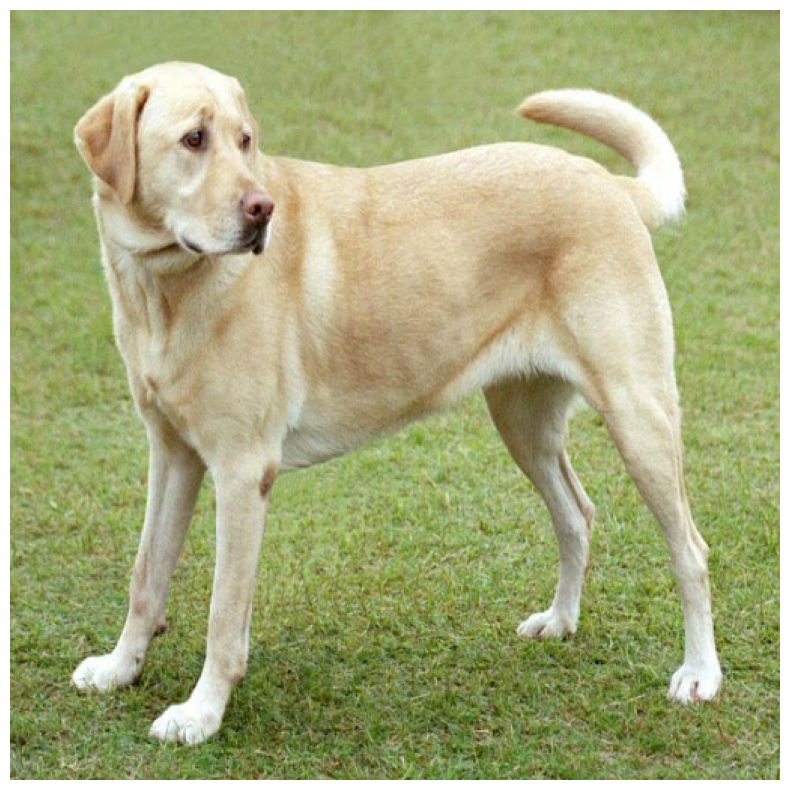

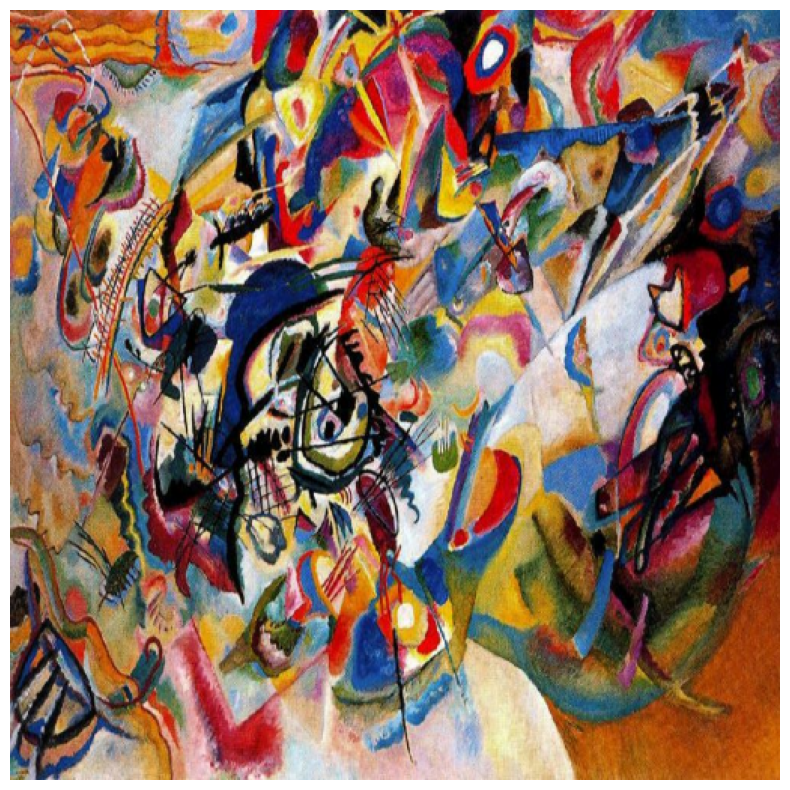

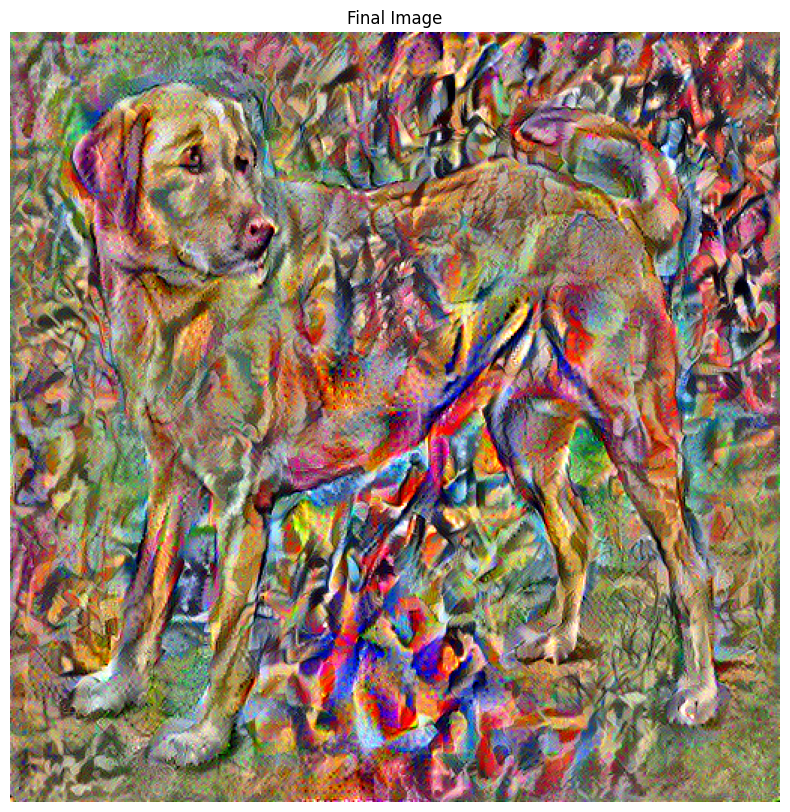

In [81]:
# Initialize the VGGModel (replace VGGModel with your actual model initialization)
vgg_model = VGGModel()
style_transfer = StyleTransfer(vgg_model)
visualizer = Visualization(style_transfer)

# Display the UI for style transfer
visualizer.style_transfer_ui()


In [11]:
plt.imsave('/content/stylized_image.png', best_img)